In [0]:
!pip install deepdish

In [0]:
import tensorflow as tf
import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import os
import deepdish.io as io
from sklearn.metrics import roc_curve, auc
import random

Using TensorFlow backend.


In [0]:
# verification of tensorflow
tf.__version__

'1.14.0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
  

In [0]:
# data from debo's data for example
data_Mix_Train = io.load(os.path.join('DarkMachineTrain.h5'))
data_Mix_Test = io.load(os.path.join('DarkMachineTest.h5'))
data_bkg_Train = io.load(os.path.join('X_bkgTrain.h5'))
data_bkg_Test = io.load(os.path.join('X_bkgTest.h5'))

In [0]:
# setup of data for training/testing 
X_Mix_train = data_Mix_Train['X']
y_Mix_train = data_Mix_Train['y']
X_Mix_test = data_Mix_Test['X']
y_Mix_test = data_Mix_Test['y']

X_bkg_train = data_bkg_Train['X']
X_bkg_test = data_bkg_Test['X']

X_Mix_train_N = keras.utils.normalize(X_Mix_train, axis=1)
X_Mix_test_N = keras.utils.normalize(X_Mix_test, axis=1)

y_Mix_train_N = keras.utils.normalize(y_Mix_train, axis=1)
y_Mix_test_N = keras.utils.normalize(y_Mix_test, axis=1) 

X_bkg_train_N = keras.utils.normalize(X_bkg_train, axis=1)
X_bkg_test_N = keras.utils.normalize(X_bkg_test, axis=1)



In [0]:
# verification of proper data
print("X_Mix_train_N: ",X_Mix_train_N.shape)
print("X_Mix_test_N: ",X_Mix_test_N.shape)
print("y_Mix_train_N: ",y_Mix_train.shape)
print("y_Mix_test_N: ",y_Mix_test.shape)

print("X_bkg_train_N: ",X_bkg_train_N.shape)
print("X_bkg_test_N: ",X_bkg_test_N.shape)


('X_Mix_train_N: ', (2420718, 113))
('X_Mix_test_N: ', (806907, 113))
('y_Mix_train_N: ', (2420718, 1))
('y_Mix_test_N: ', (806907, 1))
('X_bkg_train_N: ', (1739535, 113))
('X_bkg_test_N: ', (434884, 113))


In [0]:
print y_Mix_train_N

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


In [0]:
# network parameters
input_shape = X_Mix_train_N.shape[1]
high_dim = 113
mid_dim = 75
low_dim = 30
batch_size = 256
latent_dim = 16
epochs = 50

print(input_shape)

113


In [0]:
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


# Variational Autoencoder Model


In [0]:
# Variational Autoencoder (VAE) Model Start

# Encoder Model
inputs = Input(shape=(input_shape,), name='encoder_input')
eh = Dense(high_dim, activation='relu')(inputs)
em = Dense(mid_dim, activation='relu')(eh)
el = Dense(low_dim, activation='relu')(em)
z_mean = Dense(latent_dim, name='z_mean')(el)
z_log_var = Dense(latent_dim, name='z_log_var')(el)


W0829 18:03:58.582310 140486976563072 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 18:03:58.622654 140486976563072 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 18:03:58.623976 140486976563072 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


W0829 18:03:58.680694 140486976563072 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [0]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.compile(optimizer='adam', loss='mean_squared_error')
encoder.summary()
plot_model(encoder, show_shapes=True) #to_file='vae_mlp_encoder.png',


W0829 18:03:58.694518 140486976563072 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 113)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 113)          12882       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 75)           8550        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           2280        dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [0]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
dl = Dense(low_dim, activation='relu')(latent_inputs)
dm = Dense(mid_dim, activation='relu')(dl)
dh = Dense(high_dim, activation='relu')(dm)

outputs = Dense(input_shape, activation='sigmoid')(dh) # original_dim


In [0]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True) #to_file='vae_mlp_decoder.png',


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 75)                2325      
_________________________________________________________________
dense_6 (Dense)              (None, 113)               8588      
_________________________________________________________________
dense_7 (Dense)              (None, 113)               12882     
Total params: 24,305
Trainable params: 24,305
Non-trainable params: 0
_________________________________________________________________


In [0]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
#encoder.compile(optimizer='adam', loss='binary_crossentropy')
# VAE Model End
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 113)               0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  24704     
_________________________________________________________________
decoder (Model)              (None, 113)               24305     
Total params: 49,009
Trainable params: 49,009
Non-trainable params: 0
_________________________________________________________________


# Binary Classifier Model

In [0]:
# Binary Classifier (Functional API) Model Start

binputs = Input(shape=(latent_dim,), name='binary_input')
bi = Dense(latent_dim, activation= 'relu')(binputs)
bioutputs = Dense(1, activation='sigmoid')(bi)

biclass = Model(binputs, bioutputs, name='binary_classifer')
biclass.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

biclass.summary()


W0829 18:03:59.783804 140486976563072 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0829 18:03:59.787472 140486976563072 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
binary_input (InputLayer)    (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________



# Training Variational Autoencoder with Pure Background


In [0]:
##########################################
# Start Model Combination & Verification #
##########################################

In [0]:
# Variational Autoencoder (VAE) Training/Testing [BACKGROUND]
history = vae.fit(X_bkg_train_N,X_bkg_train_N,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[es])
                  #validation_data=(X_bkg_test_N, X_bkg_test_N)) #shuffle=True


encoder.save_weights('ve-weights.h5')
vae.save_weights('vae-weights.h5')

vae.save('DarkMachine_autoencoder.model')
encoder.save('DarkMachine_encoder.model')

Train on 1391628 samples, validate on 347907 samples
Epoch 1/50
1391628/1391628 [==============================] - 36s 26us/step - loss: 0.0013 - acc: 0.9045 - val_loss: 2.2258e-04 - val_acc: 0.9505
Epoch 2/50
1391628/1391628 [==============================] - 31s 22us/step - loss: 1.1486e-04 - acc: 0.9629 - val_loss: 2.4332e-05 - val_acc: 0.9603
Epoch 3/50
1391628/1391628 [==============================] - 31s 22us/step - loss: 1.2970e-05 - acc: 0.9762 - val_loss: 1.2326e-05 - val_acc: 0.9768
Epoch 4/50
1391628/1391628 [==============================] - 31s 22us/step - loss: 8.2141e-06 - acc: 0.9801 - val_loss: 1.0606e-05 - val_acc: 0.9804
Epoch 5/50
1391628/1391628 [==============================] - 31s 23us/step - loss: 5.7102e-06 - acc: 0.9835 - val_loss: 5.6830e-06 - val_acc: 0.9808
Epoch 6/50
1391628/1391628 [==============================] - 32s 23us/step - loss: 4.5287e-06 - acc: 0.9851 - val_loss: 5.0488e-06 - val_acc: 0.9922
Epoch 7/50
1391628/1391628 [=======================

['acc', 'loss', 'val_acc', 'val_loss']


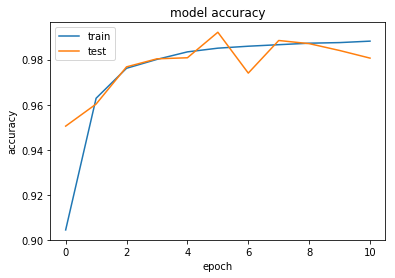

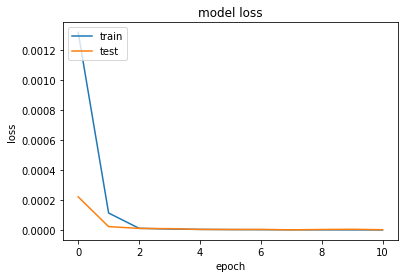

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# accuracy doesn't matter, especially for variational autoencoders
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
encoder_model = keras.models.load_model('DarkMachine_encoder.model')

In [0]:
# Encoder as input, using Mixed Data
# Training Input
x_train_encoded = encoder_model.predict(X_Mix_train_N, batch_size=batch_size)
# Testing Input
x_test_encoded = encoder_model.predict(X_Mix_test_N, batch_size=batch_size)

## Binary Classifier with Pure Background Encoder Input
##### (Remember: Implies classification using only latent space representation)

In [0]:
# Binary Classifer Training/Testing 
## Classifer can be used for both VAE's 
history = biclass.fit(x_train_encoded[0], 
                      y_Mix_train_N, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_split=0.2,
                      callbacks=[es])
                      #validation_data=(x_test_encoded[0], y_Mix_test_N))


biclass.save_weights('bi-weights.h5')
biclass.save('binary-class.model')

Train on 1936574 samples, validate on 484144 samples
Epoch 1/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1980 - acc: 0.9226 - val_loss: 0.1634 - val_acc: 0.9370
Epoch 2/50
1936574/1936574 [==============================] - 24s 12us/step - loss: 0.1569 - acc: 0.9400 - val_loss: 0.1513 - val_acc: 0.9422
Epoch 3/50
1936574/1936574 [==============================] - 24s 12us/step - loss: 0.1485 - acc: 0.9436 - val_loss: 0.1467 - val_acc: 0.9435
Epoch 4/50
1936574/1936574 [==============================] - 24s 12us/step - loss: 0.1440 - acc: 0.9456 - val_loss: 0.1421 - val_acc: 0.9455
Epoch 5/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1412 - acc: 0.9469 - val_loss: 0.1398 - val_acc: 0.9473
Epoch 6/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1392 - acc: 0.9477 - val_loss: 0.1373 - val_acc: 0.9481
Epoch 7/50
1936574/1936574 [==============================] - 24s 12us/step - loss: 0.1377 - ac

['acc', 'loss', 'val_acc', 'val_loss']


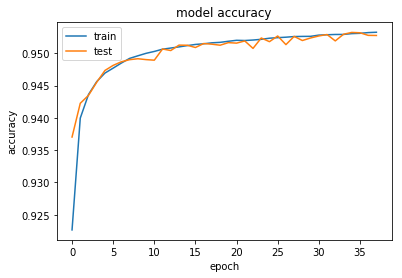

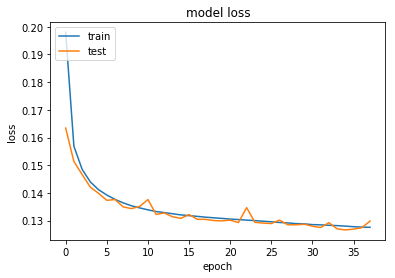

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
bi_classifier = keras.models.load_model('binary-class.model')

pred_x = bi_classifier.predict(x_test_encoded[0])

## ROC Curve for Binary Classifier

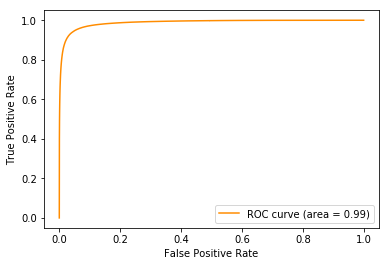

In [0]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Mix_test_N, pred_x)

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## Histogram & ROC Curve of VAE

In [0]:
vae_predict_x = vae.predict(X_Mix_test_N)

In [0]:
# Mean Square Root for prediction of loss
predict_loss_mse = np.mean(np.power(X_Mix_test_N - vae_predict_x, 2), axis=1)

In [0]:
predict_loss_mse = predict_loss_mse.reshape(806907,1)
predict_loss_mse.shape

(806907, 1)

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

predict_loss=predict_loss_mse
tf_loss=StandardScaler().fit(predict_loss.reshape(-1,1))
predict_loss=tf_loss.transform(predict_loss.reshape(-1,1))

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


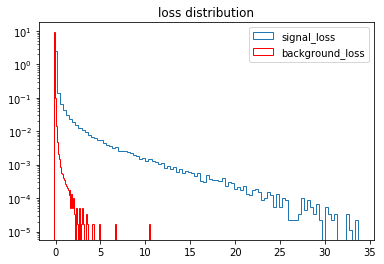

In [0]:

sigPred = predict_loss[np.where(y_Mix_test==1)]
bkgPred = predict_loss[np.where(y_Mix_test==0)]
fig = plt.hist(sigPred, bins=100, histtype='step', label='signal_loss', normed= 1)
fig = plt.hist(bkgPred, bins=100, histtype='step', color= 'red', label='background_loss', normed= 1)
fig = plt.yscale('log')
fig = plt.legend(loc= 'upper right')
fig = plt.title('loss distribution')

('roc_auc =', 0.9031671738324631)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


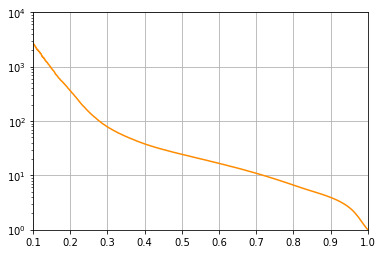

In [0]:
from sklearn.metrics import roc_auc_score

fpr_vae, tpr_vae, thresholds_vae = roc_curve(y_Mix_test, predict_loss)
roc_auc = roc_auc_score(y_Mix_test, predict_loss)
print("roc_auc =", roc_auc_score(y_Mix_test, predict_loss))

plt.plot(tpr_vae, 1/fpr_vae, color = 'darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim(0.1, 1.0)
plt.ylim(1, 10000)
plt.yscale("log")
plt.grid()
plt.show()


# Training VAE with Mixed Data
### [ Mixed = Background + Signal ]


In [0]:
# Variational Autoencoder (VAE) Training/Testing [MIXED]
history = vae.fit(X_Mix_train_N,X_Mix_train_N,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[es])
                  #validation_data=(X_Mix_test_N, X_Mix_test_N)) #shuffle=True


encoder.save_weights('ve-mix-weights.h5')
vae.save_weights('vae-mix-weights.h5')

vae.save('DarkMachine_autoencoder-mix.model')
encoder.save('DarkMachine_encoder-mix.model')

Train on 1936574 samples, validate on 484144 samples
Epoch 1/50
1936574/1936574 [==============================] - 44s 23us/step - loss: 9.2752e-06 - acc: 0.9868 - val_loss: 4.6483e-06 - val_acc: 0.9817
Epoch 2/50
1936574/1936574 [==============================] - 44s 23us/step - loss: 4.0526e-06 - acc: 0.9880 - val_loss: 3.0279e-06 - val_acc: 0.9901
Epoch 3/50
1936574/1936574 [==============================] - 45s 23us/step - loss: 3.2400e-06 - acc: 0.9889 - val_loss: 2.6770e-06 - val_acc: 0.9913
Epoch 4/50
1936574/1936574 [==============================] - 44s 23us/step - loss: 2.8181e-06 - acc: 0.9893 - val_loss: 2.7181e-06 - val_acc: 0.9954
Epoch 5/50
1936574/1936574 [==============================] - 45s 23us/step - loss: 2.5455e-06 - acc: 0.9894 - val_loss: 2.3107e-06 - val_acc: 0.9938
Epoch 6/50
1936574/1936574 [==============================] - 45s 23us/step - loss: 2.3356e-06 - acc: 0.9901 - val_loss: 2.5873e-06 - val_acc: 0.9928
Epoch 7/50
1936574/1936574 [===================

['acc', 'loss', 'val_acc', 'val_loss']


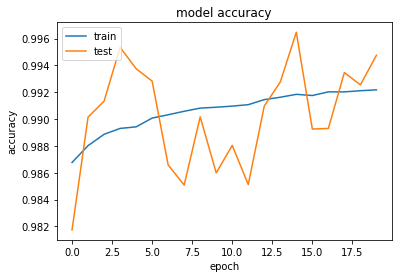

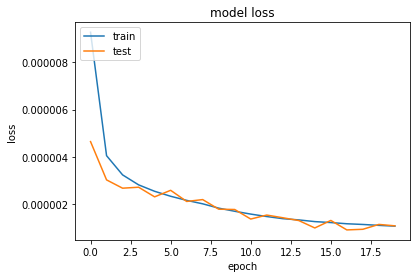

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
encoder_mix_model = keras.models.load_model('DarkMachine_encoder-mix.model')
vae_mix_model = keras.models.load_model('DarkMachine_autoencoder-mix.model')

In [0]:
# Mixed Encoder as input, using Mixed Data
# Training Input
x_train_encoded_mix = encoder_mix_model.predict(X_Mix_train_N, batch_size=batch_size)
# Testing Input
x_test_encoded_mix = encoder_mix_model.predict(X_Mix_test_N, batch_size=batch_size)

## Binary Classifier with Mixed Encoder Input

In [0]:
# Binary Classifer Training/Testing (Sequential)
## Classifer can be used for both VAE's 
history = biclass.fit(x_train_encoded_mix[0], 
                      y_Mix_train_N, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_split=0.2,
                      callbacks=[es])
                      #validation_data=(x_test_encoded_mix[0], y_Mix_test_N))


biclass.save_weights('bi-mix-weights.h5')
biclass.save('binary-mix-class.model')

Train on 1936574 samples, validate on 484144 samples
Epoch 1/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1431 - acc: 0.9497 - val_loss: 0.1172 - val_acc: 0.9575
Epoch 2/50
1936574/1936574 [==============================] - 24s 12us/step - loss: 0.1135 - acc: 0.9592 - val_loss: 0.1100 - val_acc: 0.9603
Epoch 3/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1087 - acc: 0.9608 - val_loss: 0.1071 - val_acc: 0.9612
Epoch 4/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1054 - acc: 0.9620 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 5/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1033 - acc: 0.9629 - val_loss: 0.1029 - val_acc: 0.9631
Epoch 6/50
1936574/1936574 [==============================] - 24s 12us/step - loss: 0.1022 - acc: 0.9633 - val_loss: 0.1023 - val_acc: 0.9630
Epoch 7/50
1936574/1936574 [==============================] - 25s 13us/step - loss: 0.1012 - ac

['acc', 'loss', 'val_acc', 'val_loss']


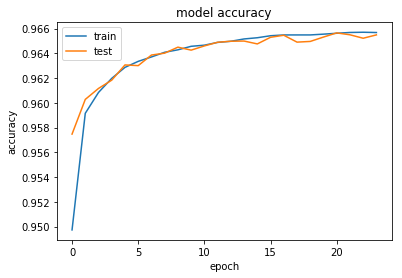

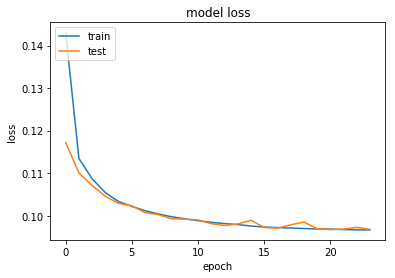

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
bi_mix_classifier = keras.models.load_model('binary-mix-class.model')

pred_mix_x = bi_mix_classifier.predict(x_test_encoded_mix[0])

## Mixed Input Binary Classifier ROC Curve

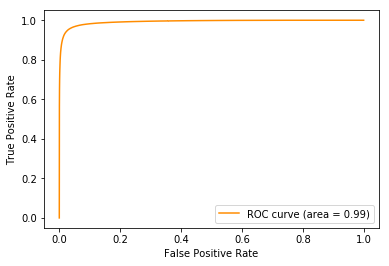

In [0]:
fpr_mb, tpr_mb, _ = roc_curve(y_Mix_test_N, pred_mix_x)

roc_auc_mb = auc(fpr_mb, tpr_mb)

plt.plot(fpr_mb,tpr_mb,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc_mb)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## Histogram & ROC Curve of Mixed VAE

In [0]:
vae_mix_predict_x = vae_mix_model.predict(X_Mix_test_N)
predict_loss_mse = np.mean(np.power(X_Mix_test_N - vae_mix_predict_x, 2), axis=1)
predict_loss_mse = predict_loss_mse.reshape(806907,1)
predict_loss_mse.shape

(806907, 1)

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

predict_loss=predict_loss_mse
tf_loss=StandardScaler().fit(predict_loss.reshape(-1,1))
predict_loss=tf_loss.transform(predict_loss.reshape(-1,1))

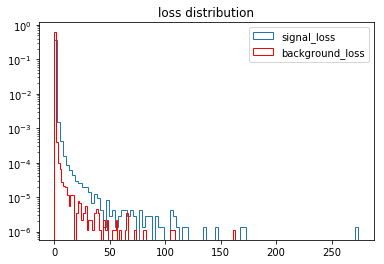

In [0]:
sigPred = predict_loss[np.where(y_Mix_test==1)]
bkgPred = predict_loss[np.where(y_Mix_test==0)]
fig = plt.hist(sigPred, bins=100, histtype='step', label='signal_loss', normed= 1)
fig = plt.hist(bkgPred, bins=100, histtype='step', color= 'red', label='background_loss', normed= 1)
fig = plt.yscale('log')
fig = plt.legend(loc= 'upper right')
fig = plt.title('loss distribution')

('roc_auc =', 0.6111050688110579)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


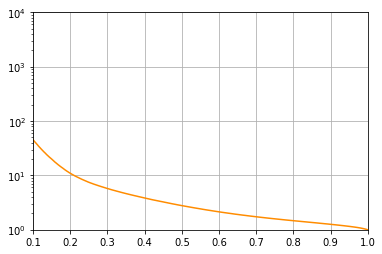

In [0]:
from sklearn.metrics import roc_auc_score

fpr_vae_mix, tpr_vae_mix, thresholds_vae_mix = roc_curve(y_Mix_test, predict_loss)
roc_auc = roc_auc_score(y_Mix_test, predict_loss)
print("roc_auc =", roc_auc_score(y_Mix_test, predict_loss))

plt.plot(tpr_vae_mix, 1/fpr_vae_mix, color = 'darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim(0.1, 1.0)
plt.ylim(1, 10000)
plt.yscale("log")
plt.grid()
plt.show()